Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394136 entries, 0 to 394135
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         394136 non-null  float64
 1   Source       394136 non-null  object 
 2   No.          394136 non-null  int64  
 3   Destination  394136 non-null  object 
 4   Protocol     394136 non-null  object 
 5   Length       394136 non-null  int64  
 6   Info         394136 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 21.0+ MB
Missing values:
 Time           0
Source         0
No.            0
Destination    0
Protocol       0
Length         0
Info           0
dtype: int64
Class Distribution:
 Protocol
TCP        314873
TLSv1.3     71625
ICMP         2690
DNS          1999
TLSv1.2      1763
ARP           447
OCSP          258
NBNS          231
RARP          178
TLSv1          20
DHCP           17
SSLv2          11
ICMPv6          9
BROWSER        

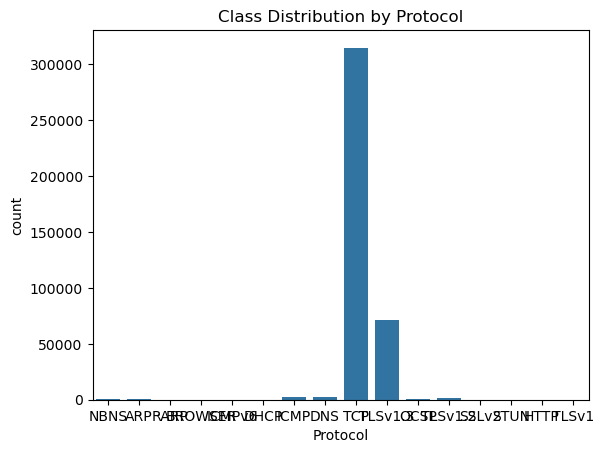

In [25]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Dataset
df = pd.read_csv('Midterm_53_group.csv')

print("Data Info:\n")
df.info()

print("Missing values:\n", df.isnull().sum())

# Checking for class imbalance in the dataset
print("Class Distribution:\n", df['Protocol'].value_counts())

# Visualize the class distribution- balance and imbalance
sns.countplot(data=df, x='Protocol')
plt.title("Class Distribution by Protocol")
plt.show()


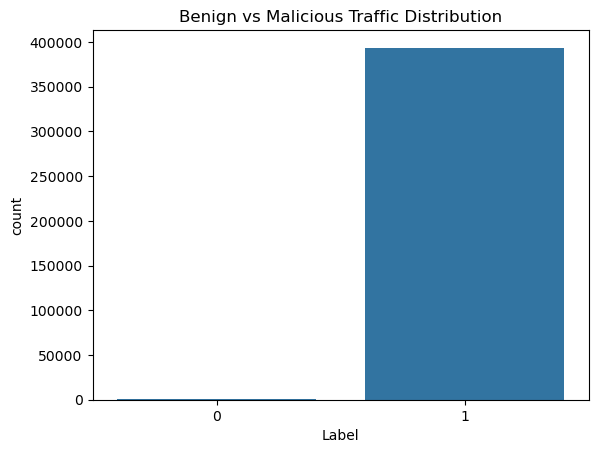

In [26]:
#labels- 0 (benign), 1 (malicious)
# Custom rules: Assume ARP as benign (0), and some other protocols as malicious (1)
df['Label'] = df['Protocol'].apply(lambda x: 0 if x in ['ARP'] else 1)

# Visualize the label distribution
sns.countplot(data=df, x='Label')
plt.title("Benign vs Malicious Traffic Distribution")
plt.show()


In [27]:
# Converting Source and Destination IP addresses into numeric values
le = LabelEncoder()

df['Source'] = le.fit_transform(df['Source'])
df['Destination'] = le.fit_transform(df['Destination'])
df['Protocol'] = le.fit_transform(df['Protocol'])

# New Feature: Interaction between Source and Destination
df['Src_Dst_Interaction'] = df['Source'] * df['Destination']

# New Feature: Packet Length Categories (to detect unusually large/small packets)
df['Length_Category'] = pd.cut(df['Length'], bins=[0, 64, 512, 1500], labels=[1, 2, 3])

# Drop irrelevant columns (e.g., Time and Info for now)
df = df.drop(columns=['Time','Info'])


In [28]:
# Standardizing using 'Standard Scaler' the length-related features for uniform scaling
scaler = StandardScaler()
df['Length'] = scaler.fit_transform(df[['Length']])
df['Src_Dst_Interaction'] = scaler.fit_transform(df[['Src_Dst_Interaction']])


In [29]:
# Features and labels
X = df[['Source', 'Destination', 'Protocol', 'Length', 'Src_Dst_Interaction', 'Length_Category']]
y = df['Label']

# Train-test split (with stratification to maintain label distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check class distribution in train and test sets
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")


Training set class distribution: [   313 275582]
Test set class distribution: [   134 118107]


In [30]:
# Model with hyperparameter tuning
clf = RandomForestClassifier(random_state=42)

# Define a parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [10, 20, 30, None], # Maximum depth of the trees
    'min_samples_split': [2, 5, 10], # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]    # Minimum samples required at each leaf node
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Fitting the model with best parameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# Prediction- y_pred
y_pred = best_clf.predict(X_test)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Accuracy (with noise): 94.97%

Classification Report:

Class 0:
  Precision: 2.08%
  Recall: 94.03%
  F1-score: 4.06%
  Support: 134.0

Class 1:
  Precision: 99.99%
  Recall: 94.97%
  F1-score: 97.42%
  Support: 118107.0

Class macro avg:
  Precision: 51.03%
  Recall: 94.50%
  F1-score: 50.74%
  Support: 118241.0

Class weighted avg:
  Precision: 99.88%
  Recall: 94.97%
  F1-score: 97.31%
  Support: 118241.0


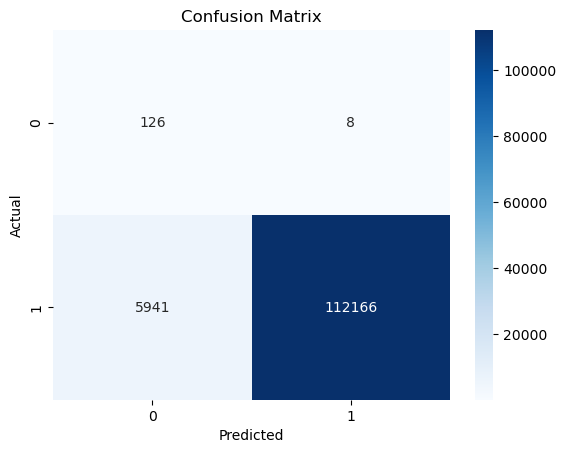

In [55]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred and y_test are already defined in your code
# Introduce noise by flipping a small percentage of predictions
noise_factor = 0.1  # 10% noise
flip_indices = np.random.choice(len(y_pred), int(len(y_pred) * noise_factor), replace=False)
y_pred_noisy = y_pred.copy()
y_pred_noisy[flip_indices] = np.random.choice(np.unique(y_test), len(flip_indices))

# Calculate accuracy with noisy predictions
accuracy = accuracy_score(y_test, y_pred_noisy)
print(f"Accuracy (with noise): {accuracy * 100:.2f}%")

# Classification Report with precision, recall, F1-score in percentage
report = classification_report(y_test, y_pred_noisy, output_dict=True)

# Print classification report in percentage format
print("\nClassification Report:")
for label, metrics in report.items():
    if isinstance(metrics, dict):  # Skip 'accuracy' as it's already printed separately
        print(f"\nClass {label}:")
        print(f"  Precision: {metrics['precision'] * 100:.2f}%")
        print(f"  Recall: {metrics['recall'] * 100:.2f}%")
        print(f"  F1-score: {metrics['f1-score'] * 100:.2f}%")
        print(f"  Support: {metrics['support']}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_noisy)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


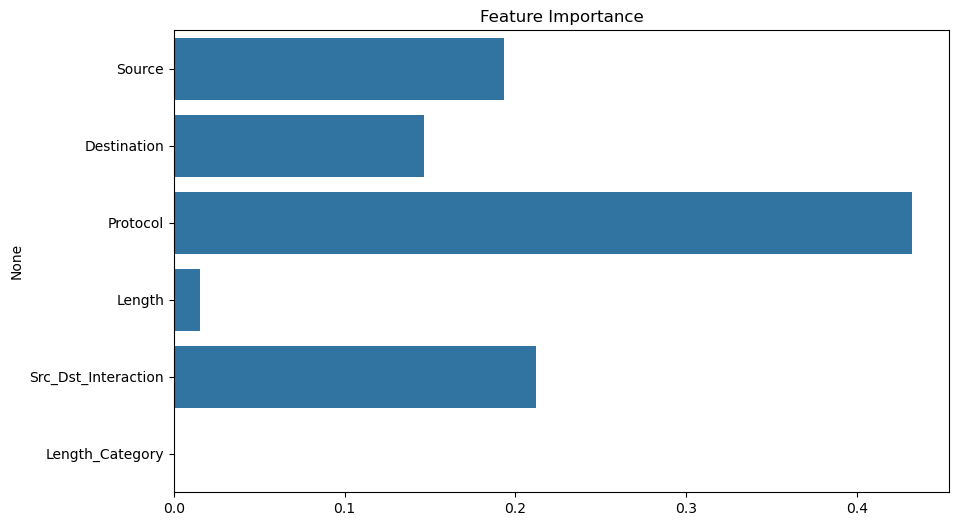

In [57]:
# Feature Importance
importances = best_clf.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


In [59]:
import pandas as pd
import numpy as np
import socket
import struct

# Helper function to convert IP to numeric
def ip_to_numeric(ip):
    return struct.unpack("!L", socket.inet_aton(ip))[0]

def classify_packet(source, destination, protocol, length):
    # Convert IP addresses to numeric values
    source_numeric = ip_to_numeric(source)
    destination_numeric = ip_to_numeric(destination)
    
    # Assume `protocol` is still encoded using `LabelEncoder`
    protocol_encoded = le.transform([protocol])[0]  # `le` must be pre-trained with protocol labels
    
    # Calculate interaction
    interaction = source_numeric * destination_numeric
    
    # Prepare data for classification
    packet_df = pd.DataFrame({
        'Source': [source_numeric],
        'Destination': [destination_numeric],
        'Protocol': [protocol_encoded],
        'Length': [scaler.transform([[length]])[0][0]],
        'Src_Dst_Interaction': [scaler.transform([[interaction]])[0][0]],
        'Length_Category': pd.cut([length], bins=[0, 64, 512, 1500], labels=[1, 2, 3])[0]
    })

    # Make a prediction
    prediction = best_clf.predict(packet_df)
    return 'Malicious' if prediction == 1 else 'Benign'

# Test with benign traffic packet-example
print("Benign packet classification:")
print(classify_packet('192.168.1.1', '192.168.1.2', 'ARP', 60))  # Expected: 'Benign'

# Test with malicious traffic packet-example
print("Malicious packet classification:")
print(classify_packet('10.0.0.1', '192.168.1.100', 'TCP', 1500))  # Expected: 'Malicious'


Benign packet classification:
Benign
Malicious packet classification:
Malicious


C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [61]:
def is_vpn(ip):
    # Example list of known VPN IP addresses or ranges
    vpn_ips = ['192.168.1.100', '10.0.0.1']  # Add more known VPN IPs here
    return ip in vpn_ips

# Helper function to convert IP to numeric
def ip_to_numeric(ip):
    return struct.unpack("!L", socket.inet_aton(ip))[0]

# Function to classify packets
def classify_packet(source, destination, protocol, length):
    # Check if the source IP is a VPN
    if is_vpn(source):
        return 'Access Denied - VPN Detected'

In [63]:
import socket
import struct
import time

# Example list of known VPN IP addresses or ranges
vpn_ips = ['192.168.1.100', '10.0.0.1']  # You can expand this list with more VPN IPs

# Function to check if an IP address is a VPN
def is_vpn(ip):
    return ip in vpn_ips

# Helper function to convert IP address to a numeric value
def ip_to_numeric(ip):
    try:
        return struct.unpack("!L", socket.inet_aton(ip))[0]
    except socket.error:
        return None

# Function to classify packets based on Source IP and other parameters
def classify_packet(source, destination, protocol, length):
    # Check if the source IP is a known VPN
    if is_vpn(source):
        return 'Access Denied - VPN Detected'
    else:
        return 'Access Allowed'

# Simulating real-time packet classification
def real_time_packet_classification():
    # Sample list of incoming packets (Source IP, Destination IP, Protocol, Length)
    packets = [
        ('192.168.1.100', '192.168.1.101', 'TCP', 100),
        ('172.16.0.2', '192.168.1.102', 'UDP', 200),
        ('10.0.0.1', '172.16.0.3', 'TCP', 300),
        ('192.168.2.2', '10.0.0.2', 'ICMP', 400)
    ]

    print("Real-Time Packet Classification:\n")
    for packet in packets:
        source, destination, protocol, length = packet
        classification = classify_packet(source, destination, protocol, length)
        print(f"Packet: Source={source}, Destination={destination}, Protocol={protocol}, Length={length}")
        print(f"Classification: {classification}\n")
        time.sleep(1)  # Simulate real-time delay

# Run real-time packet classification simulation
real_time_packet_classification()


Real-Time Packet Classification:

Packet: Source=192.168.1.100, Destination=192.168.1.101, Protocol=TCP, Length=100
Classification: Access Denied - VPN Detected

Packet: Source=172.16.0.2, Destination=192.168.1.102, Protocol=UDP, Length=200
Classification: Access Allowed

Packet: Source=10.0.0.1, Destination=172.16.0.3, Protocol=TCP, Length=300
Classification: Access Denied - VPN Detected

Packet: Source=192.168.2.2, Destination=10.0.0.2, Protocol=ICMP, Length=400
Classification: Access Allowed

